Large portions of code are taken from NASA GES DISC API documentation

In [ ]:
import datetime
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sys, json, urllib3, certifi, requests, os, pandas as pd
from time import sleep

In [ ]:
!pip install netCDF4
!pip install cartopy
!pip uninstall shapely
!pip install shapely --no-binary shapely
import netCDF4 as nc4
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

Uninstalling Shapely-1.7.1:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/Shapely-1.7.1-py3.7.egg-info
    /usr/local/lib/python3.7/dist-packages/shapely/*
Proceed (y/n)? y
  Successfully uninstalled Shapely-1.7.1
  Using cached https://files.pythonhosted.org/packages/42/f3/0e1bc2c4f15e05e30c6b99322b9ddaa2babb3f43bc7df2698efdc1553439/Shapely-1.7.1.tar.gz
Skipping wheel build for shapely, due to binaries being disabled for it.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
    Running setup.py install for shapely ... done


In [ ]:
!pip install CoolProp
import CoolProp.CoolProp as CP
from CoolProp.HumidAirProp import HAPropsSI
from CoolProp.CoolProp import PropsSI

In [ ]:
## Mount google drive to run on Colab
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/Colab Notebooks/OtherResearch/AWH research/"
!pwd
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/OtherResearch/AWH research
/content/drive/My Drive/Colab Notebooks/OtherResearch/AWH research
 AWH_compileddata_FORMEONLY.csv
 AWH_supplementalCode.ipynb
 contourplots.ipynb
 datacoverage.svg
 globalmaps.ipynb
 How_to_read_and_plot_NetCDF_MERRA-2_data_in_Python.ipynb
 humidity_map.pdf
 humidity_map.png
 humidity_map.svg
 humidity_variance.pdf
 humidity_variance.svg
 Leastwork_map2.svg
 Leastwork_map.png
 Leastwork_map.svg
 lw_fullcompute.csv
 LW_map.csv
 MOF_isotherm_reg.ipynb
 nc4data
 opt_process.svg
 opt_tech_map.csv
'Psychometric Contour Plots'
 subset_M2TMNXSLV_5.12.4_20210410_042819.txt
 temperature_map.pdf
 temperature_map.png
 temperature_map.svg
 temperature_variance.pdf
 temperature_variance.svg
 test_AWHcode.ipynb


In [ ]:
## Data downloader

root_path = "/content/drive/My Drive/Colab Notebooks/OtherResearch/AWH research/"
data_path = root_path + "nc4data/"
try: 
  print("Making room to store data...")
  os.mkdir(data_path)
except OSError as error:
  print("Directory already exists:", data_path)

url_list = "subset_M2TMNXSLV_5.12.4_20210410_042819.txt"

a_file = open(url_list, "r")
link_list = []
for line in a_file:
  stripped_line = line.strip()
  link_list.append(stripped_line)
link_list = link_list[3:]   #remove first 3 links which are documentation
t_steps = len(link_list)
print(t_steps)
for i in range(t_steps):
  print(link_list[i])

Making room to store data...
Directory already exists: /content/drive/My Drive/Colab Notebooks/OtherResearch/AWH research/nc4data/
25
https://goldsmr4.gesdisc.eosdis.nasa.gov/daac-bin/OTF/HTTP_services.cgi?FILENAME=%2Fdata%2FMERRA2_MONTHLY%2FM2TMNXSLV.5.12.4%2F2019%2FMERRA2_400.tavgM_2d_slv_Nx.201901.nc4&FORMAT=bmM0Lw&BBOX=-90%2C-180%2C90%2C180&LABEL=MERRA2_400.tavgM_2d_slv_Nx.201901.SUB.nc&FLAGS=remapbil%2Cgeos1x1&SHORTNAME=M2TMNXSLV&SERVICE=L34RS_MERRA2&VERSION=1.02&DATASET_VERSION=5.12.4&VARIABLES=QV2M%2CT2M
https://goldsmr4.gesdisc.eosdis.nasa.gov/daac-bin/OTF/HTTP_services.cgi?FILENAME=%2Fdata%2FMERRA2_MONTHLY%2FM2TMNXSLV.5.12.4%2F2019%2FMERRA2_400.tavgM_2d_slv_Nx.201902.nc4&FORMAT=bmM0Lw&BBOX=-90%2C-180%2C90%2C180&LABEL=MERRA2_400.tavgM_2d_slv_Nx.201902.SUB.nc&FLAGS=remapbil%2Cgeos1x1&SHORTNAME=M2TMNXSLV&SERVICE=L34RS_MERRA2&VERSION=1.02&DATASET_VERSION=5.12.4&VARIABLES=QV2M%2CT2M
https://goldsmr4.gesdisc.eosdis.nasa.gov/daac-bin/OTF/HTTP_services.cgi?FILENAME=%2Fdata%2FMERRA2_MO

In [ ]:
def create_table(filename, x_title, y_title, z_title):
  df = pd.read_csv(filename)
  Z = df[[x_title, y_title, z_title]]
  Z_table = pd.pivot_table(Z, values = z_title, index = y_title, columns = x_title)
  return Z_table, df

filename = 'AWH_compileddata_FORMEONLY.csv'
LW_table, df = create_table(filename, 'T', 'W', 'LW')

In [ ]:
### Use split to simplify file names. replace '.' with '_'
import glob
g = glob.glob('nc4data/**')
g

['nc4data/MERRA2_400.tavgM_2d_slv_Nx.201901.SUB.nc',
 'nc4data/MERRA2_400.tavgM_2d_slv_Nx.201902.SUB.nc',
 'nc4data/MERRA2_400.tavgM_2d_slv_Nx.201904.SUB.nc',
 'nc4data/MERRA2_400.tavgM_2d_slv_Nx.201903.SUB.nc',
 'nc4data/MERRA2_400.tavgM_2d_slv_Nx.201905.SUB.nc',
 'nc4data/MERRA2_400.tavgM_2d_slv_Nx.201906.SUB.nc',
 'nc4data/MERRA2_400.tavgM_2d_slv_Nx.201907.SUB.nc',
 'nc4data/MERRA2_400.tavgM_2d_slv_Nx.201908.SUB.nc',
 'nc4data/MERRA2_400.tavgM_2d_slv_Nx.201909.SUB.nc',
 'nc4data/MERRA2_400.tavgM_2d_slv_Nx.201910.SUB.nc',
 'nc4data/MERRA2_400.tavgM_2d_slv_Nx.201912.SUB.nc',
 'nc4data/MERRA2_400.tavgM_2d_slv_Nx.202001.SUB.nc',
 'nc4data/MERRA2_400.tavgM_2d_slv_Nx.201911.SUB.nc',
 'nc4data/MERRA2_400.tavgM_2d_slv_Nx.202002.SUB.nc',
 'nc4data/MERRA2_400.tavgM_2d_slv_Nx.202005.SUB.nc',
 'nc4data/MERRA2_400.tavgM_2d_slv_Nx.202007.SUB.nc',
 'nc4data/MERRA2_400.tavgM_2d_slv_Nx.202006.SUB.nc',
 'nc4data/MERRA2_400.tavgM_2d_slv_Nx.202003.SUB.nc',
 'nc4data/MERRA2_400.tavgM_2d_slv_Nx.202004.SU

In [ ]:
## Loop through all the files in the data folder and place them in a numpy array with [lat long, time, variable]

months = len(g)
data_array = np.zeros([181,360, months, 2])  #[lat, long, months, variables]

for i, file in enumerate(g):
  nc = nc4.Dataset(file)
  data_array[:,:, i, 0] = nc['T2M'][0,:,:]
  data_array[:,:, i, 1] = nc['QV2M'][0,:,:]


In [ ]:
data_array.shape

(181, 360, 25, 2)

In [ ]:
P = 101325  #Assume atmospheric pressure
fluid = "Water"
mixture = 'Air'

def gibbs_HA(T,P,W, T_0):
    # This function calculates the flow exergy of a humid air mixture, on a basis of humid air
    # When T_0 = T, the specific gibbs function is equivalent to the flow exergy.
    # T: Temperature in K
    # P: Pressure in Pa
    # rh: Relative humidity [0,1]
    # T_0: Dead state temperature
    h = HAPropsSI('Hha','T', T, 'P', P, 'W',W)
    s = HAPropsSI('Sha','T', T, 'P', P, 'W',W)
    g = h-T_0*s
    return g

def gibbs_satv(T, T_0):
    # This function calculates the flow exergy of saturated water. 
    # The exergy in the liquid and vapor states are equivalent.
    # When T_0 = T, the specific gibbs function is equivalent to the flow exergy.
    # T: Temperature in K
    # T_0: Dead state temperature
    h = PropsSI('H','T', T, 'Q',0,fluid)
    s = PropsSI('S','T', T, 'Q',0,fluid)
    g = h-T_0*s
    return g

def calcLW(T,W,r= 0.1, P = 101325):
    # This function calculates the minimum LW for water harvesting, using the flow exergy formulation.
    # The limit to infinitesimal recovery is numerically evaluated using a polynomial fit.
    # T: Ambient temperature in K
    # P: Ambient pressure in Pa
    # rh: Ambient relative humidity [0,1]
    # r: initial recovery ratio (for numerical purposes, it doesn't really matter as long as r < 1)
    if T< 274:
      return np.NAN
    #if W<0.00001:
    #  return np.NAN
    
    dw = []
    sep = []
    for i in np.arange(0, 3, 1):
        dw.append(r * W)
        W_reject = W * (1 - r)
        G_p = gibbs_satv(T, T)
        G_f = gibbs_HA(T, P, W, T)
        G_b = gibbs_HA(T, P, W_reject, T)
        sep.append((G_p + G_b * (1 - dw[i]) / dw[i] - G_f / dw[i]) / 1000)
        r = r / 2
        #print(r, dw[i], sep[i])
    z = np.polyfit(dw, sep, 2)
    f = np.poly1d(z)
    min_sep = f(0)
    if min_sep <0:
      return 0  #sometimes we get numerical errors near saturation and get near-zero negative numbers
    return min_sep

calcLW_vec = np.vectorize(calcLW)

In [ ]:
mean_data = np.mean(data_array, axis = 2)
median_data = np.median(data_array, axis = 2)
var_data = np.var(data_array, axis = 2)
lon = np.linspace(-180,180, 360)
lat  = np.linspace(-90,90, 181)
temp = median_data[:,:,0]
humd = median_data[:,:,1]

LW = calcLW_vec(temp, humd)

In [ ]:
np.savetxt('lw_fullcompute.csv', LW, delimiter = ',')

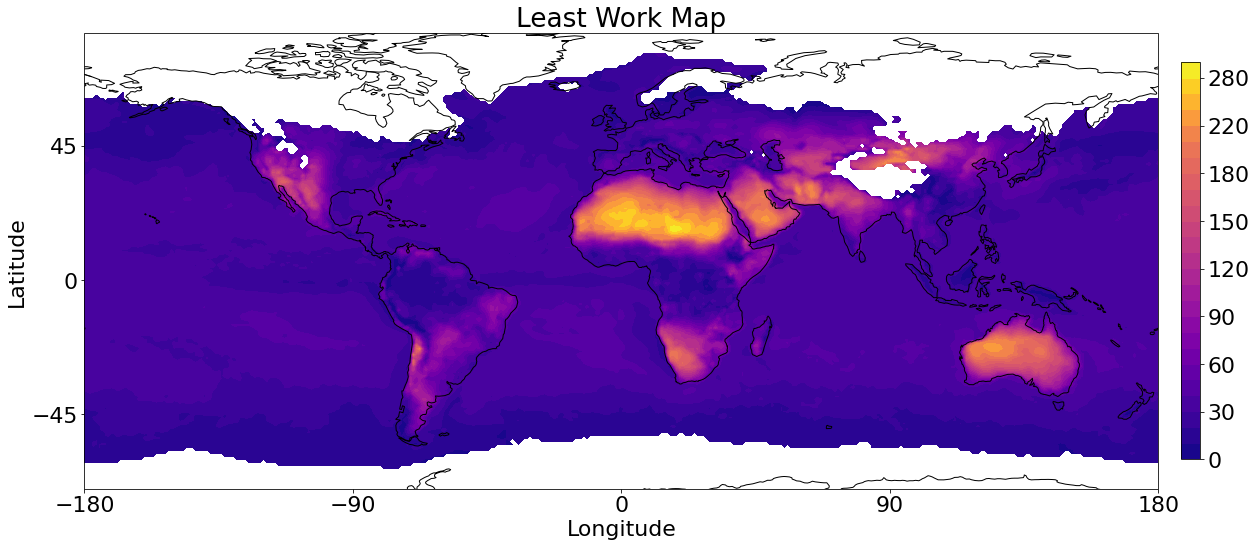

In [ ]:
#import matplotlib
projection = ccrs.PlateCarree()

colMap = plt.cm.plasma
colMap.set_bad(color='k', alpha = 1.0)
colMap.set_under(color='lightgrey', alpha = 1.0)

L_lw = np.linspace(0,200, 21)
L_lw = np.append(L_lw, np.asarray([220,240,260, 280, 300]))
fig, ax = plt.subplots(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree())
h = ax.contourf(lon, lat, LW, L_lw, cmap = colMap)
ax.set_title('Least Work Map')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_xticks(np.linspace(-180, 180, 5), crs=projection)
ax.set_yticks(np.linspace(-90, 90, 5), crs=projection)
ax.coastlines()
fig.colorbar(h, ax = ax, fraction = 0.0178, pad = 0.02)
matplotlib.rcParams.update({'font.size': 22})
ax.plot()
fig.savefig('Leastwork_map2.svg')

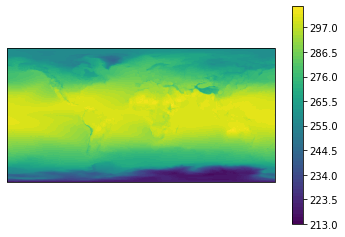

In [ ]:
mean_data = np.mean(data_array, axis = 2)
median_data = np.median(data_array, axis = 2)
var_data = np.var(data_array, axis = 2)
lon = np.linspace(-180,180, 360)
lat  = np.linspace(-90,90, 181)
temp = median_data[:,:,0]
humd = median_data[:,:,1]

temp_var = var_data[:,:,0]
humd_var = var_data[:,:,1]

def plotmap(data_array, i): 
  fig, ax = plt.subplots(dpi = 150)
  im = ax.imshow(data_array[:,:,i,1])#, cmap = 'plasma')
  fig.colorbar(im, ax=ax)
  plt.show()


ax = plt.axes(projection=ccrs.PlateCarree())
plt.contourf(lon, lat, temp , 60, transform=ccrs.PlateCarree())
#ax.contourf(data_array[:,:,0,1])
#ax.coastlines()
plt.colorbar()



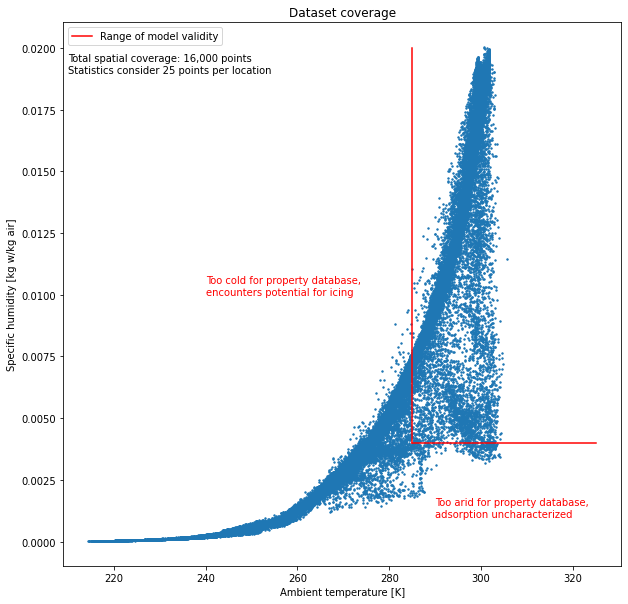

In [ ]:
flatline_x = np.linspace(285,325)
flatline_y = np.linspace(0.004,0.004)
flatline_x2 = np.linspace(285,285)
flatline_y2 = np.linspace(0.004,0.02)
color = 'r'
fig, ax = plt.subplots(figsize = (10,10))
ax.scatter(temp.flatten(), humd.flatten(), s = 2)
ax.plot(flatline_x, flatline_y, color, label = 'Range of model validity')
ax.plot(flatline_x2, flatline_y2, color)
ax.set_ylabel('Specific humidity [kg w/kg air]')
ax.set_xlabel('Ambient temperature [K]')
ax.set_title('Dataset coverage')
plt.text(240,0.01, 'Too cold for property database,\nencounters potential for icing', c = color)
plt.text(290,0.001, 'Too arid for property database,\nadsorption uncharacterized', c = color)
plt.text(210,0.019, 'Total spatial coverage: 16,000 points\nStatistics consider 25 points per location', c = 'k')
plt.legend(loc = 'upper left');
fig.savefig('datacoverage.svg')

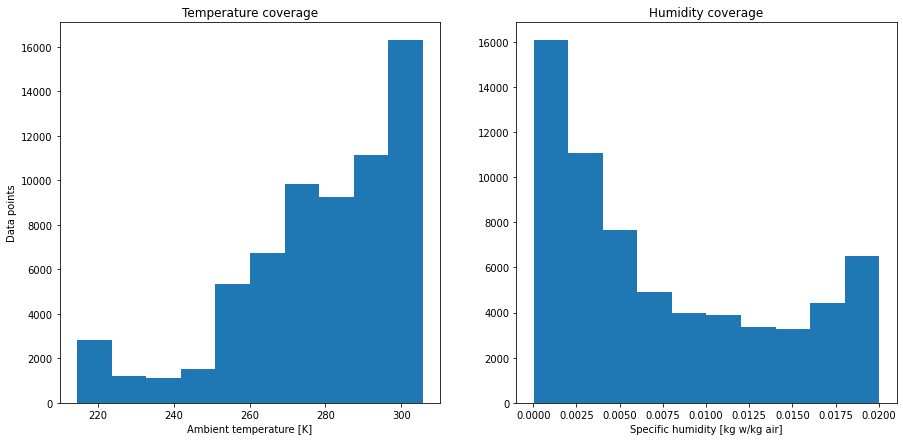

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (15,7))
ax[0].hist(temp.flatten())
ax[1].hist(humd.flatten())
ax[1].set_xlabel('Specific humidity [kg w/kg air]')
ax[0].set_xlabel('Ambient temperature [K]')
ax[0].set_ylabel('Data points')
ax[0].set_title('Temperature coverage');
ax[1].set_title('Humidity coverage');

In [ ]:
T = round(temp[100,239],4)
print(T)
W = round(humd[100,239],3)
print(W)
#LW_table.lookup(T, W)
#LW_table.where(LW_table['T'].values == T)
temp_filtered = df.where(round(df['T'],1) == T).dropna(axis='rows')
humd_filtered = temp_filtered.where(round(temp_filtered['W'],3) == W).dropna(axis='rows')
humd_filtered

300.2157
0.018


,Unnamed: 0,T,W,RH,LW,Dew,Recovery,Membrane_LP,Membrane,Mem_eff,MOF_801,Min,Process,Soft_min,Unnamed: 14


In [ ]:
LW_table

T,280.000000,280.302013,280.604027,280.906040,281.208054,281.510067,281.812081,282.114094,282.416107,282.718121,283.020134,283.322148,283.624161,283.926175,284.228188,284.530201,284.832215,285.134228,285.436242,285.738255,286.040269,286.342282,286.644295,286.946309,287.248322,287.550336,287.852349,288.154362,288.456376,288.758389,289.060403,289.362416,289.664429,289.966443,290.268456,290.570470,290.872483,291.174497,291.476510,291.778524,...,313.221476,313.523490,313.825503,314.127517,314.429530,314.731544,315.033557,315.335571,315.637584,315.939597,316.241611,316.543624,316.845638,317.147651,317.449664,317.751678,318.053691,318.355705,318.657718,318.959731,319.261745,319.563758,319.865772,320.167785,320.469799,320.771812,321.073825,321.375839,321.677852,321.979866,322.281879,322.583893,322.885906,323.187919,323.489933,323.791946,324.093960,324.395973,324.697987,325.000000
W,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.004040,54.778075,57.502710,60.226601,62.949749,65.672154,68.393819,71.114743,73.834927,76.554372,79.273080,81.991050,84.708285,87.424783,90.140548,92.855578,95.569876,98.283441,100.996275,103.708379,106.419753,109.130399,111.840316,114.549506,117.257970,119.965707,122.672721,125.379010,128.084575,130.789419,133.493540,136.196941,138.899622,141.601583,144.302825,147.003350,149.703158,152.402249,155.100625,157.798286,160.495232,...,350.197780,352.845164,355.491885,358.137942,360.783336,363.428068,366.072138,368.715547,371.358296,374.000385,376.641815,379.282587,381.922700,384.562157,387.200957,389.839101,392.476589,395.113423,397.749602,400.385129,403.020002,405.654222,408.287791,410.920709,413.552977,416.184595,418.815563,421.445883,424.075554,426.704579,429.332956,431.960687,434.587772,437.214213,439.840009,442.465161,445.089670,447.713536,450.336761,452.959343
0.004295,46.956000,49.671405,52.386068,55.099988,57.813166,60.525604,63.237303,65.948262,68.658483,71.367968,74.076715,76.784728,79.492005,82.198549,84.904360,87.609438,90.313785,93.017402,95.720288,98.422446,101.123875,103.824577,106.524553,109.223802,111.922327,114.620127,117.317204,120.013558,122.709191,125.404102,128.098293,130.791764,133.484517,136.176551,138.867868,141.558469,144.248353,146.937523,149.625979,152.313721,...,341.363744,344.001949,346.639490,349.276368,351.912583,354.548136,357.183028,359.817259,362.450830,365.083742,367.715994,370.347588,372.978525,375.608805,378.238428,380.867395,383.495707,386.123365,388.750368,391.376719,394.002416,396.627462,399.251856,401.875598,404.498691,407.121134,409.742928,412.364073,414.984571,417.604421,420.223625,422.842182,425.460094,428.077361,430.693984,433.309963,435.925299,438.539993,441.154045,443.767455
0.004550,39.592169,42.298840,45.004769,47.709956,50.414403,53.118110,55.821078,58.523307,61.224800,63.925556,66.625576,69.324861,72.023413,74.721231,77.418317,80.114672,82.810295,85.505189,88.199353,90.892790,93.585498,96.277480,98.968736,101.659267,104.349073,107.038156,109.726516,112.414154,115.101070,117.787266,120.472742,123.157499,125.841538,128.524860,131.207464,133.889353,136.570526,139.250985,141.930730,144.609762,...,333.042411,335.671931,338.300788,340.928982,343.556514,346.183384,348.809592,351.435140,354.060028,356.684257,359.307827,361.930739,364.552994,367.174591,369.795533,372.415819,375.035450,377.654426,380.272749,382.890418,385.507435,388.123800,390.739514,393.354577,395.968990,398.582753,401.195868,403.808334,406.420152,409.031324,411.641848,414.251727,416.860961,419.469550,422.077495,424.684796,427.291454,429.897470,432.502844,435.107577
0.004805,32.636668,35.335047,38.032683,40.729579,43.425735,46.121152,48.815831,51.509772,54.202977,56.895446,59.587180,62.278180,64.968446,67.657980,70.346783,73.034854,75.722196,78.408808,81.094692,83.779848,86.464277,89.147980,91.830958,94.513211,97.194741,99.875547,102.555631,105.234994,107.913635,110.591557,113.268760,115.945244,118.621011,121.296060,123.970394,126.644012,129.316915,131.989104,134.660580,

In [ ]:
test = [([1.70242355]), ([4.16741699]), ([]), ([np.NAN])]
test = [x for x in test if x != []]
len(test)
#np.nanmean(test )
#np.nansum(test)


3

In [ ]:
import scipy
from scipy.interpolate import RegularGridInterpolator


def find_neighbours(value, df, colname):
    exactmatch = df[df[colname] == value]
    if not exactmatch.empty:
        return exactmatch.index
    else:
        lowerneighbour_ind = df[df[colname] < value][colname].idxmax()
        upperneighbour_ind = df[df[colname] > value][colname].idxmin()
        return [lowerneighbour_ind, upperneighbour_ind] 

def find_value2D(coord, df, col, value):
  fil1 = df.where(df[col[0]]==coord[0]).dropna(axis = 'rows')
  fil2 = df.where(fil1[col[1]]==coord[1]).dropna(axis = 'rows')
  return fil2[value].values

def interp_2d(x,y):#, xcol, ycol, value):
  xcol = 'T'
  ycol = 'W'
  value = 'Process'
  filename = 'AWH_compileddata_FORMEONLY.csv'
  df = pd.read_csv(filename)
  #xcol = cols[0]
  #ycol = cols[1]

  # if value is out of bounds, then return NaN
  if (x<280.0 or x>325.0):
    return np.NAN
  if (y<0.00404 or y>0.04):
    return np.NAN
  
  X_updown = find_neighbours(x,df,xcol)
  x_r = df.iloc[X_updown][xcol].values
  Y_updown = find_neighbours(y,df,ycol)
  y_r = df.iloc[Y_updown][ycol].values

  # to make sure we have a "rectangle" for interpolation
  if len(x_r) ==1:
    x_r = [x_r, x_r]
  if len(y_r)== 1:
    y_r = [y_r, y_r]

  # bounding box of the rectangle
  c1 = [x_r[0], y_r[0]]
  val1 = find_value2D(c1, df, [xcol, ycol], value)

  c2 = [x_r[1], y_r[0]]
  val2 = find_value2D(c2, df,  [xcol, ycol], value)

  c3 = [x_r[0], y_r[1]]
  val3 = find_value2D(c3, df,  [xcol, ycol], value)

  c4 = [x_r[1], y_r[1]]
  val4 = find_value2D(c4, df,  [xcol, ycol], value)
  
  v = [val1, val2, val3, val4]

  # More error handling
  v = [x for x in v if np.size(x)>0]
  check = np.where(v==[np.NAN], 0,1)
  if check == 0:
    return np.NAN
  
  return np.nanmedian(v)
    
  #val = [[val1, val2], [val3, val4]]

  #scipy interpolate 
  #interp = #RegularGridInterpolator([x_r, y_r], val)(coordinate)
  #return interp[0][0]

LW_val = interp_2d(320,0.0165)#, df)#, 'T','W', 'LW')
LW_val

interp_2d_vec = np.vectorize(interp_2d)#, excluded = ['df']) #,'xcol', 'ycol','value'])

In [ ]:
process_opt = np.zeros_like(temp)

process_opt[:,:] = interp_2d_vec(temp[:,:], humd[:,:])
np.savetxt('opt_tech_map.csv', process_opt, delimiter=',')

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/p

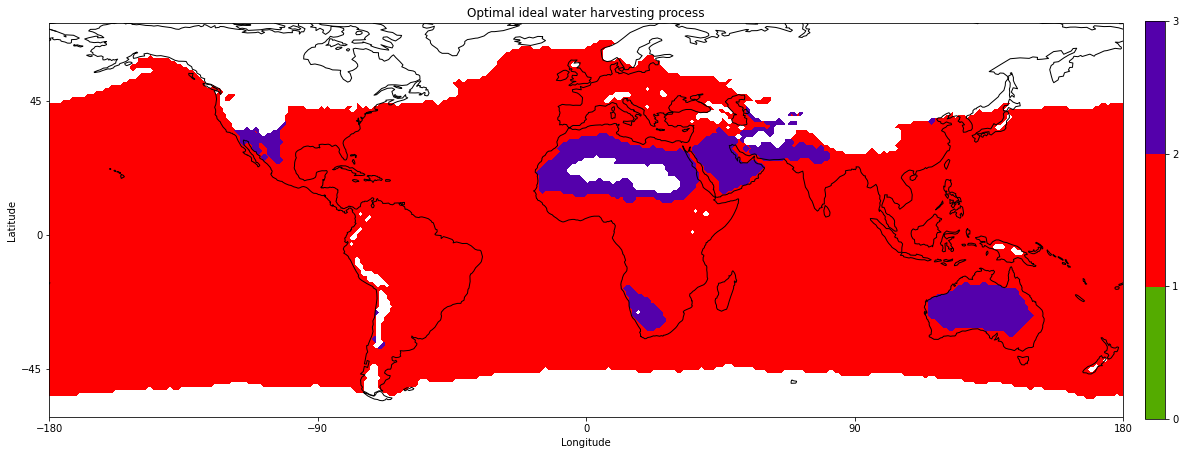

In [ ]:
projection = ccrs.PlateCarree()
process_opt_int = process_opt.round()
colMap = plt.cm.brg_r
colMap.set_bad(color='k', alpha = 1.0)
colMap.set_under(color='lightgrey', alpha = 1.0)

L_op = np.asarray([0,1,2,3])
fig, ax3 = plt.subplots(figsize=(20,10))
ax3 = plt.axes(projection=ccrs.PlateCarree())
h = ax3.contourf(lon, lat, process_opt_int, L_op, cmap = colMap)
ax3.set_title('Optimal ideal water harvesting process')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
ax3.set_xticks(np.linspace(-180, 180, 5), crs=projection)
ax3.set_yticks(np.linspace(-90, 90, 5), crs=projection)
ax3.coastlines()
fig.colorbar(h, ax = ax3, fraction = 0.0178, pad = 0.02)
ax3.plot()
fig.savefig('opt_process.svg')

In [ ]:
LW = np.zeros_like(temp)

LW[:,:] = interp_2d_vec(temp[:,:], humd[:,:])#, df)#, 'T', 'W', 'LW')

#for i in range(181):
#  for j in range(360):
#    T = temp[i,j]
#    W = humd[i,j]
#    LW[i,j] = bilinear_interp([T,W], df, ['T','W'], 'LW')



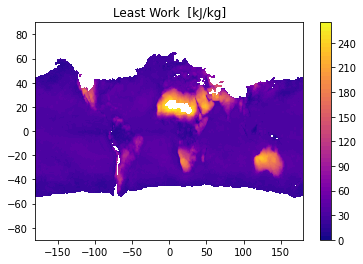

In [ ]:
plt.contourf(lon, lat, LW, 60, cmap = 'plasma')
plt.colorbar()
plt.title('Least Work  [kJ/kg]')
np.savetxt('LW_map.csv', LW, delimiter=',')
plt.savefig('Leastwork_map.png')

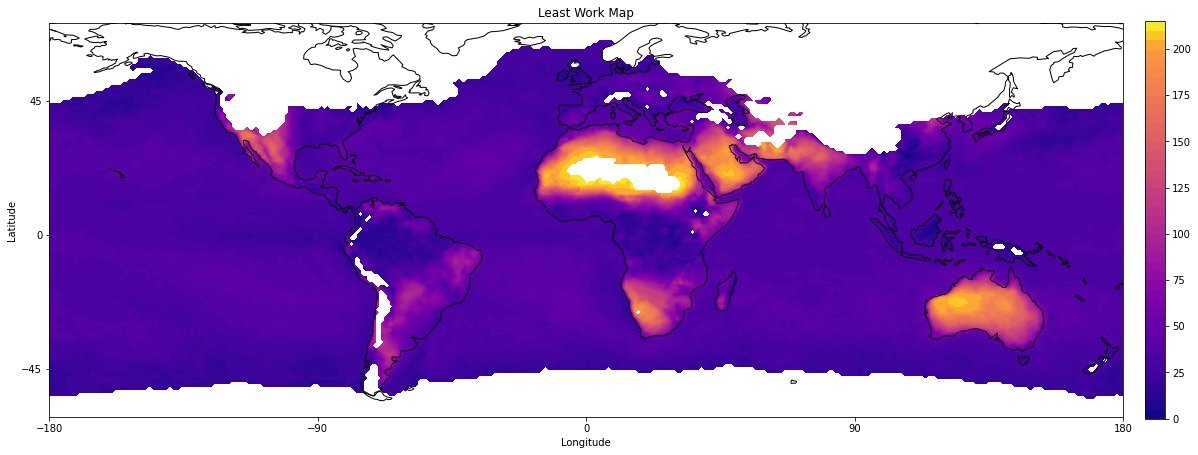

In [ ]:
projection = ccrs.PlateCarree()

colMap = plt.cm.plasma
colMap.set_bad(color='k', alpha = 1.0)
colMap.set_under(color='lightgrey', alpha = 1.0)

L_lw = np.linspace(0,200, 41)
L_lw = np.append(L_lw, np.asarray([220,240,260]))
fig, ax = plt.subplots(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree())
h = ax.contourf(lon, lat, LW, L_lw, cmap = colMap)
ax.set_title('Least Work Map')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_xticks(np.linspace(-180, 180, 5), crs=projection)
ax.set_yticks(np.linspace(-90, 90, 5), crs=projection)
ax.coastlines()
fig.colorbar(h, ax = ax, fraction = 0.0178, pad = 0.02)
ax.plot()
fig.savefig('Leastwork_map.svg')


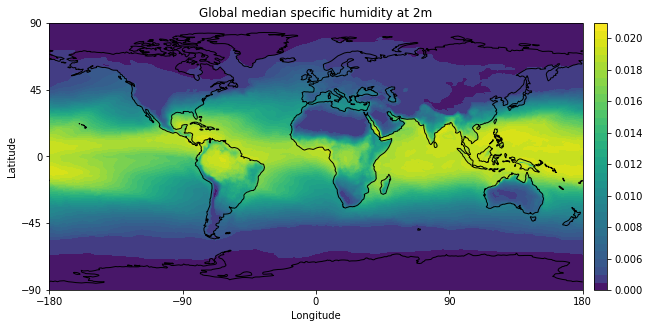

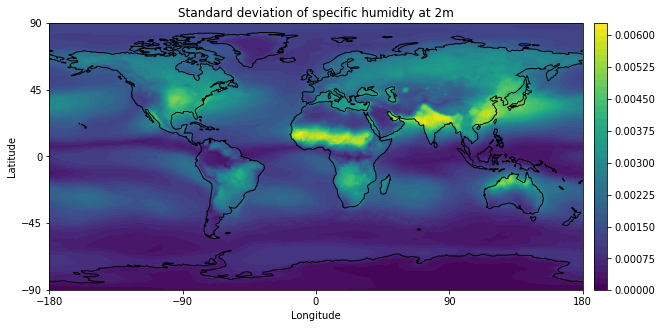

In [ ]:
fig,ax1 = plt.subplots(figsize = (10,10))
ax1 = plt.axes(projection=ccrs.PlateCarree())
L_hum = [0, 25]#[0.0, 25.0, 50.0, 75.0, 100.0, 110.0, 120.0, 130, 140, 150, 160, 170, 180, 190, 200, 210]
L_hum = np.append(np.asarray(L_hum), np.linspace(50, 210, int(160/5) + 1))/10000.0
h = ax1.contourf(lon, lat, humd , L_hum, cmap = 'viridis')
ax1.set_xticks(np.linspace(-180, 180, 5), crs=projection)
ax1.set_yticks(np.linspace(-90, 90, 5), crs=projection)
ax1.coastlines()
ax1.set_title("Global median specific humidity at 2m")
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
fig.colorbar(h,ax =ax1, fraction = 0.024, pad = 0.02)
fig.savefig('humidity_map.svg')
plt.show()

fig,ax2 = plt.subplots(figsize = (10,10))
ax2 = plt.axes(projection=ccrs.PlateCarree())
L_hum = np.linspace(0,6,37)#[0.0, 25.0, 50.0, 75.0, 100.0, 110.0, 120.0, 130, 140, 150, 160, 170, 180, 190, 200, 210]
L_hum = np.asarray(L_hum)/10000.0
h = ax2.contourf(lon, lat, np.sqrt(humd_var) , 60, cmap = 'viridis')
ax2.set_xticks(np.linspace(-180, 180, 5), crs=projection)
ax2.set_yticks(np.linspace(-90, 90, 5), crs=projection)
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.coastlines()
ax2.set_title("Standard deviation of specific humidity at 2m")
fig.colorbar(h,ax =ax2, fraction = 0.024, pad = 0.02)
fig.savefig('humidity_variance.svg')
plt.show()

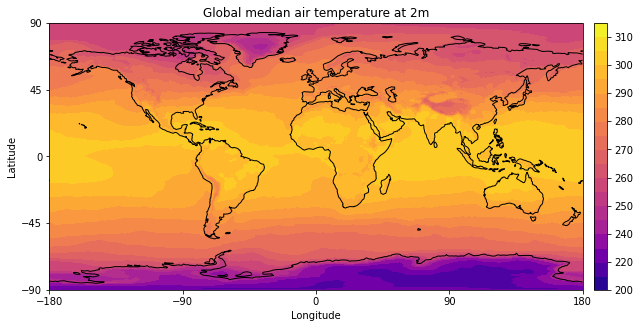

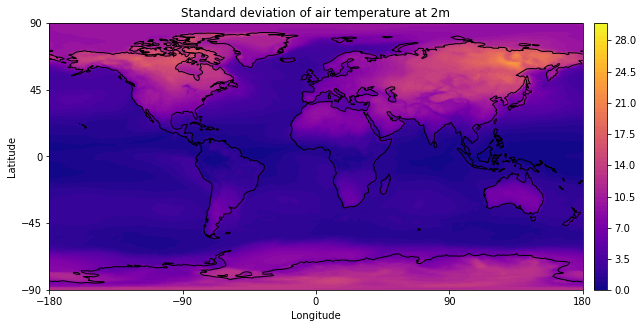

In [ ]:
projection = ccrs.PlateCarree()

fig,ax = plt.subplots(figsize = (10,10))

ax = plt.axes(projection = ccrs.PlateCarree())
L = [200, 210, 220, 230]
L = np.asarray(L)
L_temp = np.append(L, np.linspace(240,305, 14))
L_temp = np.append(L_temp, np.asarray([310,315]))
h = ax.contourf(lon, lat, temp, L_temp, cmap = 'plasma', vmax = 315)
ax.coastlines()
ax.set_xticks(np.linspace(-180, 180, 5), crs=projection)
ax.set_yticks(np.linspace(-90, 90, 5), crs=projection)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title("Global median air temperature at 2m")
fig.colorbar(h, ax = ax, fraction = 0.024, pad = 0.02 )
fig.savefig('temperature_map.svg')
plt.show()


fig,ax0 = plt.subplots(figsize = (10,10))

ax0 = plt.axes(projection = ccrs.PlateCarree())
L_temp = np.linspace(0, 30,61)
L_temp = np.asarray(L_temp)
h = ax0.contourf(lon, lat, np.sqrt(temp_var), L_temp, cmap = 'plasma')
ax0.coastlines()
ax0.set_title("Standard deviation of air temperature at 2m")
ax0.set_xticks(np.linspace(-180, 180, 5), crs=projection)
ax0.set_yticks(np.linspace(-90, 90, 5), crs=projection)
ax0.set_xlabel('Longitude')
ax0.set_ylabel('Latitude')
fig.colorbar(h, ax = ax0, fraction = 0.024, pad = 0.02 )
fig.savefig('temperature_variance.svg')
plt.show()
